In [109]:
import mysql.connector
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Connect to the database
conn = mysql.connector.connect(user='root', password='',
                           host='localhost', database='semtraclus')
print(conn)

In [84]:
mycursor = conn.cursor()
mycursor.execute("CREATE TABLE cluster_points (id INT NOT NULL AUTO_INCREMENT PRIMARY KEY,location POINT,label INT NOT NULL,user_count DOUBLE NOT NULL,time_count DOUBLE NOT NULL,point_count DOUBLE NOT NULL,final_value DOUBLE NOT NULL)")


silhouette score is 0.9897658793000991 
Noise points: 14
0.009226395088140948
Cluster 1: 181 points, average duration 6043.132596685083 seconds, 8 users, final value 0.221
0.0007461455542995098
Cluster 2: 7 points, average duration 12636.714285714286 seconds, 1 users, final value 0.027
0.00023453012188683279
Cluster 3: 4 points, average duration 6951.0 seconds, 1 users, final value 0.026
0.03704497073755084
Cluster 4: 284 points, average duration 15463.919014084508 seconds, 6 users, final value 0.176
0.0
Cluster 5: 0 points, average duration nan seconds, 0 users, final value 0.000


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


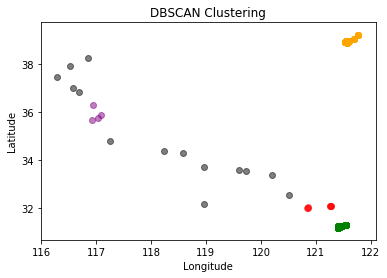

In [113]:

mycursor = conn.cursor()

import folium
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def get_location_data(table_name):
    cursor = conn.cursor()
    cursor.execute(f"SELECT ST_X(location), ST_Y(location), duration, user_id FROM {table_name}")
    results = cursor.fetchall()
    return np.array(results)

def get_location_data_extra(table_name):
    cursor = conn.cursor()
    cursor.execute(f"SELECT ST_X(location2), ST_Y(location2), duration2, user_id2 FROM {table_name}")
    results = cursor.fetchall()
    return np.array(results)

# Retrieve location data from database
location_data = get_location_data("intersecting_points")

location_data1 = get_location_data("stay_points")
location_data2 = get_location_data("repeated_rows")
extra_location_data = get_location_data_extra("intersecting_points")

# Concatenate data from all tables
all_location_data = np.concatenate([location_data, location_data1, location_data2, extra_location_data], axis=0)

# Extract spatial coordinates, duration, and user ID
spatial_coords = all_location_data[:, :2]
duration = all_location_data[:, 2]
user_id = all_location_data[:, 3]

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=4)
cluster_labels = dbscan.fit_predict(spatial_coords)

# Calculate total duration and number of users
total_time = np.sum(duration)
total_user = len(np.unique(user_id))

# Calculate silhouette score
silhouette_avg = silhouette_score(spatial_coords, cluster_labels)
print(f"silhouette score is {silhouette_avg} ")

# Initialize variables to keep track of cluster with highest final value
max_final = -float('inf')
max_cluster_points = None

# Calculate and print cluster statistics
unique_clusters = np.unique(cluster_labels)
for i, cluster in enumerate(unique_clusters):
    if cluster == -1:
        # Noise points not assigned to any cluster
        print(f"Noise points: {len(spatial_coords[cluster_labels==-1])}")
    else:
        # Cluster i contains points with label i
        cluster_points = spatial_coords[cluster_labels == i]
        cluster_duration = duration[cluster_labels == i]
        cluster_users = user_id[cluster_labels == i]
        unique_users = np.unique(cluster_users)
        num_points = len(cluster_points)
        cluster_time = np.sum(cluster_duration)
        cluster_user = len(unique_users)
        final = 0.236*(cluster_user/total_user) + 0.082*(cluster_time/total_time) + 0.682*(num_points/len(all_location_data))
        user_count=cluster_user/total_user
        time_count=cluster_time/total_time
        point_count=num_points/len(all_location_data)
        print(time_count)
        # Check if cluster has at least one point before calculating mean duration
        if len(cluster_duration) > 0:
            mean_duration = np.mean(cluster_duration)
        else:
            mean_duration = 0
        print(f"Cluster {i}: {num_points} points, average duration {np.mean(cluster_duration)} seconds, {cluster_user} users, final value {final:.3f}")
        
        sql = "INSERT INTO cluster_points (location, label, user_count, time_count, point_count, final_value) VALUES (POINT(%s, %s), %s, %s, %s, %s, %s)"
        val = (point[1], point[0], i, user_count,time_count, point_count, final)
        mycursor.execute(sql, val)
        # Commit changes and close connection
        conn.commit()

        # Update max_cluster_points if final value is higher
        if final > max_final:
            max_final = final
            max_cluster_points = cluster_points
            
            
 #Plot clusters with different colors
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, cluster in enumerate(unique_clusters):
    if cluster == -1:
        # Noise points not assigned to any cluster
        plt.scatter(spatial_coords[cluster_labels==-1, 0], spatial_coords[cluster_labels==-1, 1], color='black', alpha=0.5)
    else:
        # Cluster i contains points with label i
        cluster_points = spatial_coords[cluster_labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[i%len(colors)], alpha=0.5)

plt.title('DBSCAN Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


# Create folium map and plot cluster with highest final value
map_center = np.mean(spatial_coords, axis=0)
m = folium.Map(location=map_center[::-1], zoom_start=10)
for point in max_cluster_points:
    folium.Marker([point[1], point[0]], 
                   popup=f"Latitude: {point[1]}, Longitude: {point[0]}, Final Value: {max_final:.3f}"
                  ).add_to(m)
m


CMySQLCursor: (Nothing executed yet)
